In [96]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch
import torch.nn as nn
from sklearn.metrics import ConfusionMatrixDisplay

In [97]:
torch.manual_seed(42)

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

X_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
X_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

def filter(data, classes):
    indices = [i for i, (_, label) in enumerate(data) if label in classes]
    filtered_data = torch.utils.data.Subset(data, indices)
    return filtered_data

X_train_filtered = filter(X_train, [0, 1, 2])
X_test_filtered = filter(X_test, [0, 1, 2])

Y_train = []
for i in X_train_filtered.indices:
    Y_train.append(X_train.targets[i])

train_size = int(0.8*len(X_train_filtered))
val_size = len(X_train_filtered) - train_size
train_data_split, val_data_split = random_split(X_train_filtered, [train_size, val_size],generator=torch.Generator().manual_seed(42)
)

print(train_size)
print(val_size)

Files already downloaded and verified
Files already downloaded and verified
12000
3000


In [98]:
class CustomDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return image, label

X_train = CustomDataset(train_data_split)
X_val = CustomDataset(val_data_split)
X_test = CustomDataset(X_test_filtered)

train_loader = DataLoader(X_train, batch_size=64, shuffle=True)
val_loader = DataLoader(X_val, batch_size=64, shuffle=False)
test_loader = DataLoader(X_test, batch_size=64, shuffle=False)

print(f"Train Dataset: {len(X_train)} images")
print(f"Validation Dataset: {len(X_val)} images")
print(f"Test Dataset: {len(X_test)} images")

Train Dataset: 12000 images
Validation Dataset: 3000 images
Test Dataset: 3000 images


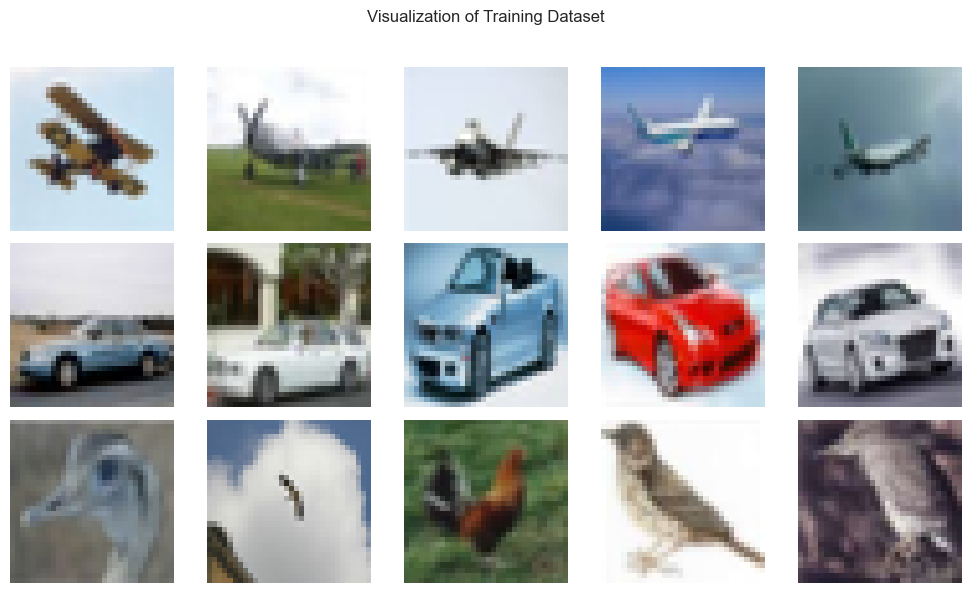

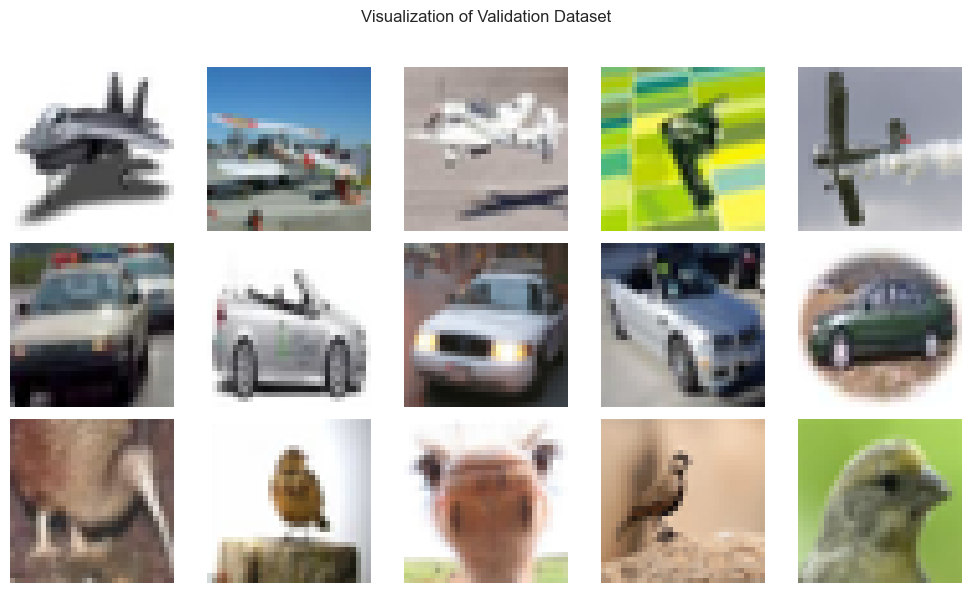

In [99]:
classes = {0: 'airplane', 1: 'automobile', 2: 'bird'}

def visualize_images(dataset, dic, n=5, split_name="D"):
    fig, axes = plt.subplots(len(dic), n, figsize=(n*2, len(dic)*2))
    fig.suptitle(f"Visualization of {split_name} Dataset", fontsize=12)

    images = {label: [] for label in dic.keys()}

    for image, label in dataset:
        if len(images[label]) < n:
            images[label].append(image)
        if all(len(images) == n for images in images.values()):
            break

    for idx, class_images in images.items():
        for i, img in enumerate(class_images):
            ax = axes[idx, i] if len(dic) > 1 else axes[i]
            img = img.permute(1, 2, 0).numpy()
            img = (img * 0.5 + 0.5)
            ax.imshow(img)
            ax.axis("off")
            if i == 0:
                ax.set_ylabel(dic[idx], fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


visualize_images(X_train, classes, n=5, split_name="Training")
visualize_images(X_val, classes, n=5, split_name="Validation")

In [100]:
class CNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=1)  
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)
        self.flatten_size = self.flatten()
        self.fc1 = nn.Linear(self.flatten_size, 16)  
        self.fc2 = nn.Linear(16, num_classes)  
    
    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))  
        x = self.pool1(x)            
        x = nn.ReLU()(self.conv2(x))  
        x = self.pool2(x)            
        x = x.view(x.size(0), -1)    
        x = nn.ReLU()(self.fc1(x))  
        x = self.fc2(x)             
        return x
    
    def flatten(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 32, 32)  
            x = self.pool1(nn.ReLU()(self.conv1(dummy_input)))
            x = self.pool2(nn.ReLU()(self.conv2(x)))
            return x.numel()

model = CNN(num_classes=3)
print(model)


CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=3, bias=True)
)


In [101]:
def training(model, train_loader, val_loader, model_name = "cnn"):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(15):
        model.train()  
        curr_loss = 0.0
        correct_out = 0
        total_samples = 0   
    
        for images, labels in train_loader: 
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            curr_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_out += (predicted == labels).sum().item()
            total_samples += labels.size(0)
    
        train_loss = curr_loss/len(train_loader)
        train_accuracy = 100*correct_out/total_samples
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
    
        model.eval()
        val_curr_loss = 0.0
        val_correct_out = 0
        val_total_samples = 0
        
        with torch.no_grad():
            for images, labels in val_loader:  
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_curr_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct_out += (predicted == labels).sum().item()
                val_total_samples += labels.size(0)
    
        val_loss = val_curr_loss/len(val_loader)
        val_accuracy = 100 * val_correct_out/val_total_samples
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
    
        print(f"Epoch [{epoch + 1}/{15}]")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    torch.save(model.state_dict(), f"{model_name}.pth")
    return train_losses, val_losses, train_accuracies, val_accuracies

In [102]:
train_losses, val_losses, train_accuracies, val_accuracies = training(model, train_loader, val_loader, "cnn")

Epoch [1/15]
Train Loss: 0.7145, Train Accuracy: 69.92%
Validation Loss: 0.5632, Validation Accuracy: 78.40%
Epoch [2/15]
Train Loss: 0.5108, Train Accuracy: 79.38%
Validation Loss: 0.4877, Validation Accuracy: 80.63%
Epoch [3/15]
Train Loss: 0.4440, Train Accuracy: 82.42%
Validation Loss: 0.4995, Validation Accuracy: 80.53%
Epoch [4/15]
Train Loss: 0.4008, Train Accuracy: 84.20%
Validation Loss: 0.4016, Validation Accuracy: 84.37%
Epoch [5/15]
Train Loss: 0.3746, Train Accuracy: 85.25%
Validation Loss: 0.4021, Validation Accuracy: 84.07%
Epoch [6/15]
Train Loss: 0.3603, Train Accuracy: 86.14%
Validation Loss: 0.3668, Validation Accuracy: 85.73%
Epoch [7/15]
Train Loss: 0.3407, Train Accuracy: 87.00%
Validation Loss: 0.3526, Validation Accuracy: 85.87%
Epoch [8/15]
Train Loss: 0.3205, Train Accuracy: 87.53%
Validation Loss: 0.3471, Validation Accuracy: 86.53%
Epoch [9/15]
Train Loss: 0.3127, Train Accuracy: 87.92%
Validation Loss: 0.3434, Validation Accuracy: 86.97%
Epoch [10/15]
Train

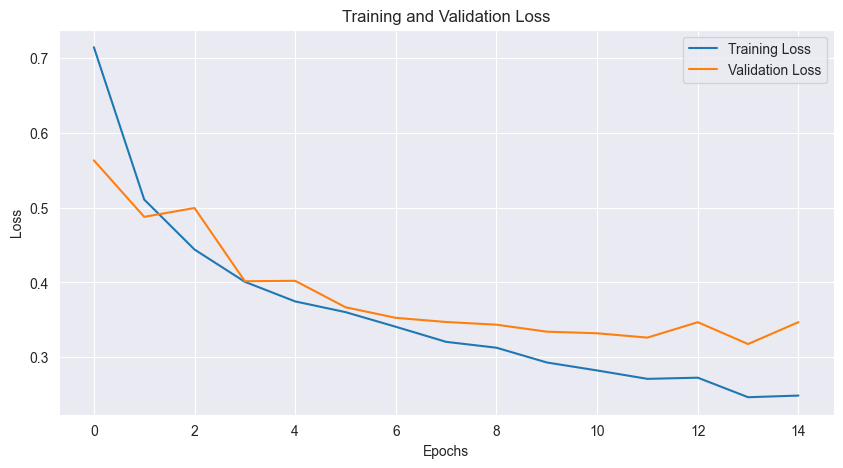

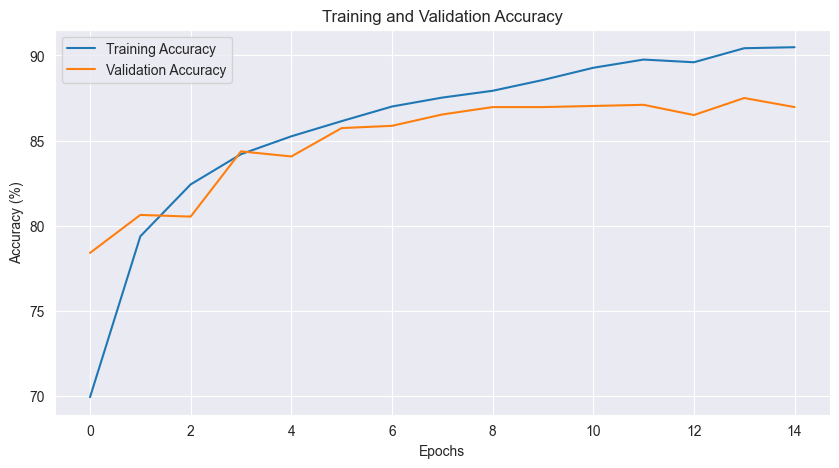

In [103]:
def plot_graph(train_losses, val_losses, train_accuracies, val_accuracies):

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()
    
plot_graph(train_losses, val_losses, train_accuracies, val_accuracies)

In [104]:
def evaluation(model, loader, dataset_type = 'training'):
    model.eval()
    predictions = []
    labels_list = []
    
    with torch.no_grad():
        for images, labels in loader: 
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.numpy())
            labels_list.extend(labels.numpy())
    
    accuracy = accuracy_score(labels_list, predictions)*100
    f1 = f1_score(labels_list, predictions, average='weighted')
    
    print(f"{dataset_type} Accuracy: {accuracy:.2f}%")
    print(f"{dataset_type} F1-Score: {f1:.4f}")
    
    cm = confusion_matrix(labels_list, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2]) 
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {dataset_type} Dataset")
    plt.show()

Train Accuracy: 90.69%
Train F1-Score: 0.9070


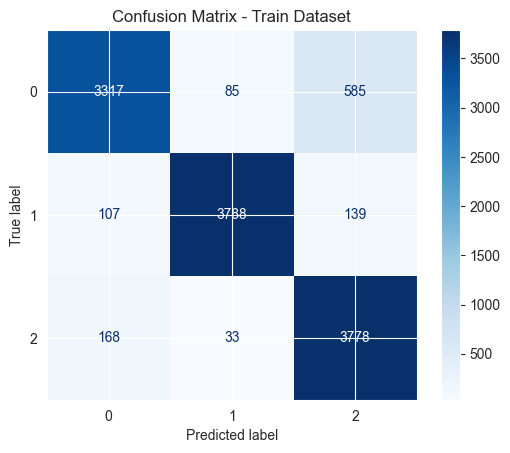

Validation Accuracy: 86.97%
Validation F1-Score: 0.8695


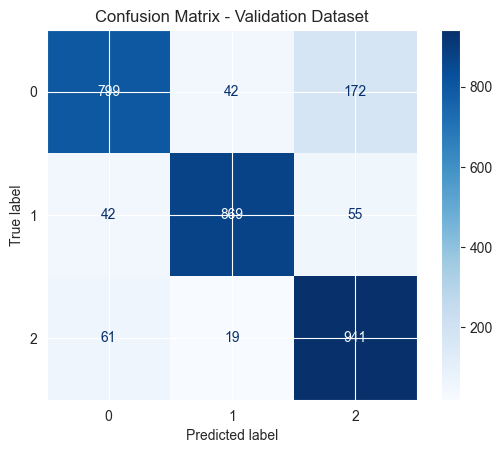

Test Accuracy: 87.43%
Test F1-Score: 0.8743


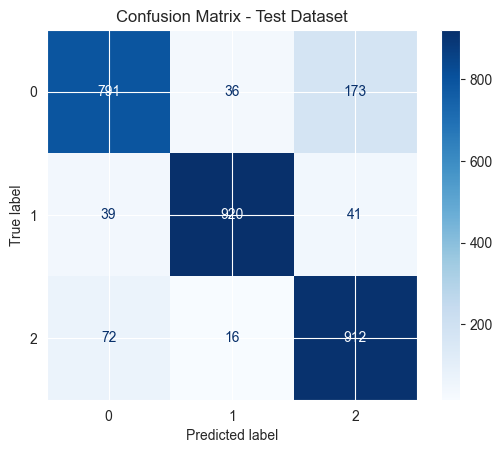

In [105]:
evaluation(model, train_loader, "Train")
evaluation(model, val_loader, "Validation")
evaluation(model, test_loader, "Test")

In [106]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes=3):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()  
        self.fc1 = nn.Linear(input_size, 64) 
        self.relu = nn.ReLU()  
        self.fc2 = nn.Linear(64, num_classes)  

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [107]:
model = MLP(3*32*32 , 3)
train_losses, val_losses, train_accuracies, val_accuracies = training(model, train_loader, test_loader, "mlp")

Epoch [1/15]
Train Loss: 0.6907, Train Accuracy: 71.68%
Validation Loss: 0.6268, Validation Accuracy: 74.67%
Epoch [2/15]
Train Loss: 0.5684, Train Accuracy: 77.42%
Validation Loss: 0.5609, Validation Accuracy: 77.00%
Epoch [3/15]
Train Loss: 0.5084, Train Accuracy: 80.31%
Validation Loss: 0.5176, Validation Accuracy: 79.17%
Epoch [4/15]
Train Loss: 0.4679, Train Accuracy: 82.18%
Validation Loss: 0.5263, Validation Accuracy: 79.30%
Epoch [5/15]
Train Loss: 0.4233, Train Accuracy: 83.88%
Validation Loss: 0.4969, Validation Accuracy: 80.93%
Epoch [6/15]
Train Loss: 0.4009, Train Accuracy: 84.86%
Validation Loss: 0.5009, Validation Accuracy: 80.70%
Epoch [7/15]
Train Loss: 0.3660, Train Accuracy: 86.32%
Validation Loss: 0.5452, Validation Accuracy: 78.93%
Epoch [8/15]
Train Loss: 0.3428, Train Accuracy: 87.03%
Validation Loss: 0.5780, Validation Accuracy: 78.20%
Epoch [9/15]
Train Loss: 0.3103, Train Accuracy: 88.37%
Validation Loss: 0.5140, Validation Accuracy: 80.33%
Epoch [10/15]
Train

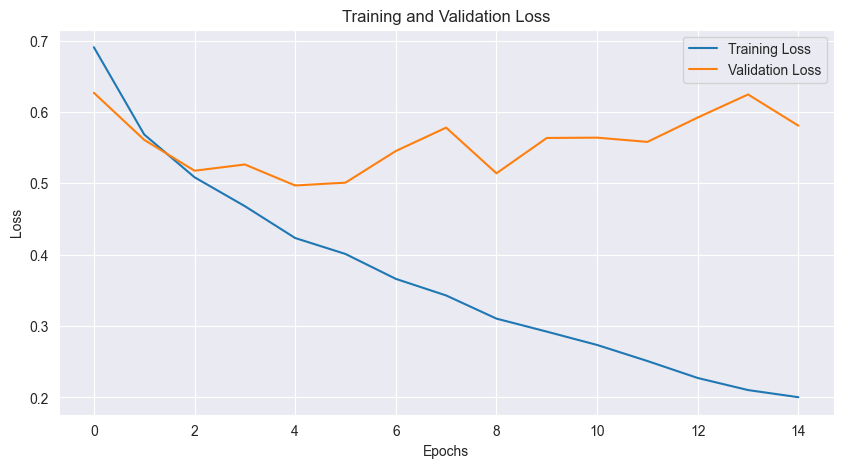

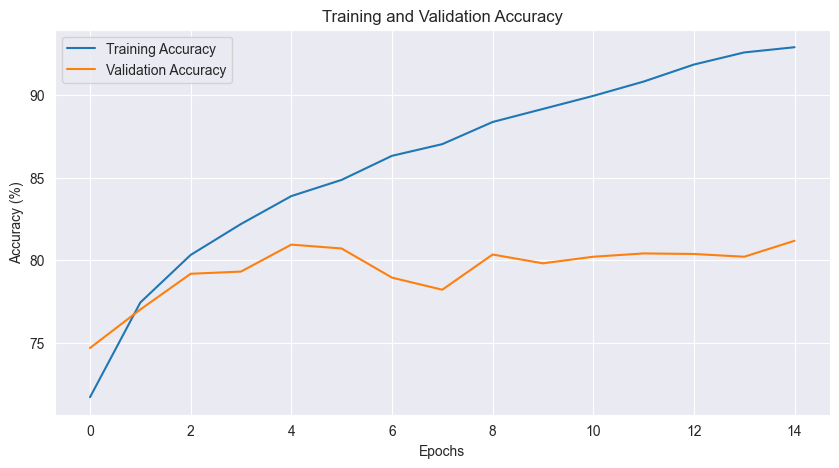

In [108]:
plot_graph(train_losses, val_losses, train_accuracies, val_accuracies)

Train Accuracy: 94.95%
Train F1-Score: 0.9493


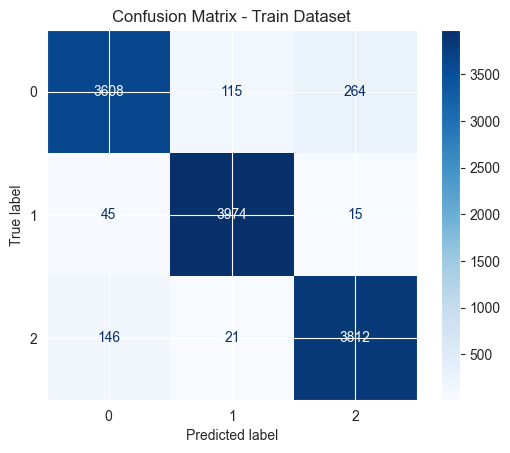

Validation Accuracy: 78.00%
Validation F1-Score: 0.7794


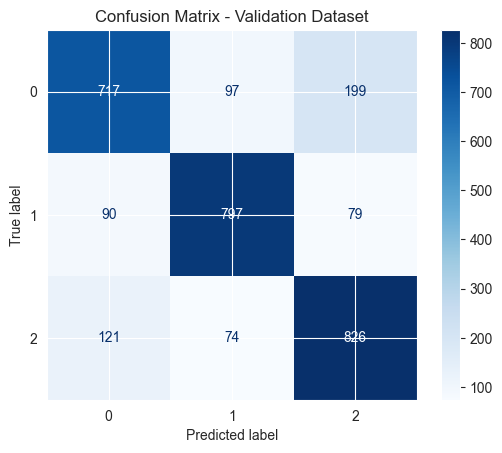

Test Accuracy: 81.17%
Test F1-Score: 0.8113


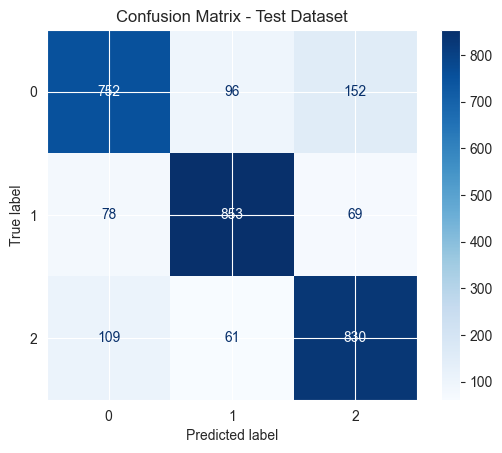

In [109]:
evaluation(model, train_loader, "Train")
evaluation(model, val_loader, "Validation")
evaluation(model, test_loader, "Test")

Observations and Comparison of CNN and MLP Model: The CNN model outperforms the MLP model in terms of accuracy and F1-score, which means that CNN is better at extracting spatial features from the image data. CNN: Shows relatively fewer misclassifications across all the chosen classes in training, validation, and test datasets, Indicating a better ability to generalize. On the contrary, MLP: More misclassifications compared to CNN, particularly in the test and validation sets, implies that MLP could be a more efficient network in terms of spatial dependency learning of data as it is completely connected. MLP: The model’s loss and accuracy graphs show that it is overfitting, which is the main issue resolved by the CNN model in comparison to other neural networks. Convolutional layers that comprise pooling operations and the capability of spatial hierarchies help the CNN perform very well on the data type of images. Its lack of mechanisms to take advantage of spatial locality puts MLP in a less-than-ideal position about this work.
Therefore, the better model was found to be CNN for this assignment’s task.


C:\Users\devch\AppData\Local\Temp\ipykernel_26744\2231397071.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cnn.pth"))


CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=3, bias=True)
)
Train Accuracy: 90.69%
Train F1-Score: 0.9070


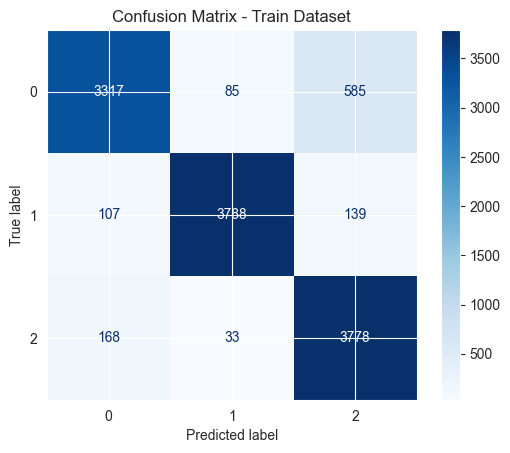

Validation Accuracy: 86.97%
Validation F1-Score: 0.8695


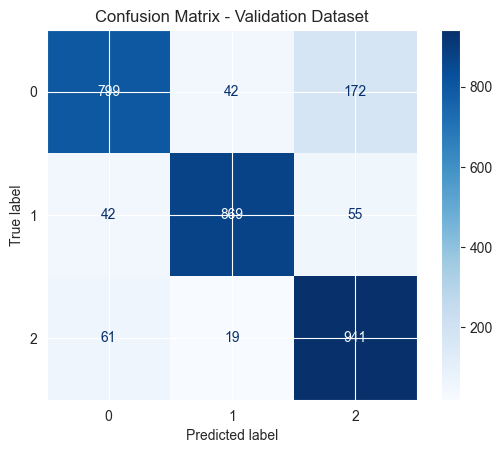

Test Accuracy: 87.43%
Test F1-Score: 0.8743


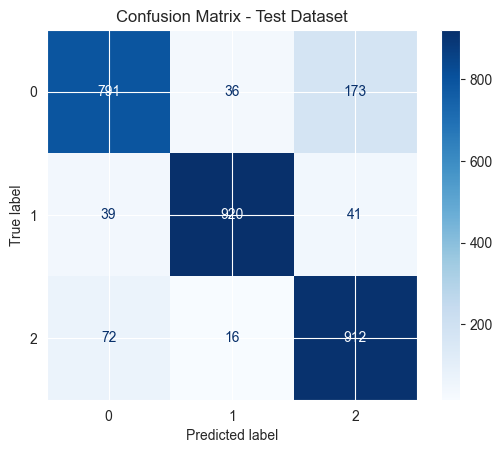

In [114]:
model = CNN(3)
model.load_state_dict(torch.load("cnn.pth"))
model.eval()

print(model)

evaluation(model, train_loader, "Train")
evaluation(model, val_loader, "Validation")
evaluation(model, test_loader, "Test")

C:\Users\devch\AppData\Local\Temp\ipykernel_26744\1787615386.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mlp.pth"))


MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)
Train Accuracy: 94.95%
Train F1-Score: 0.9493


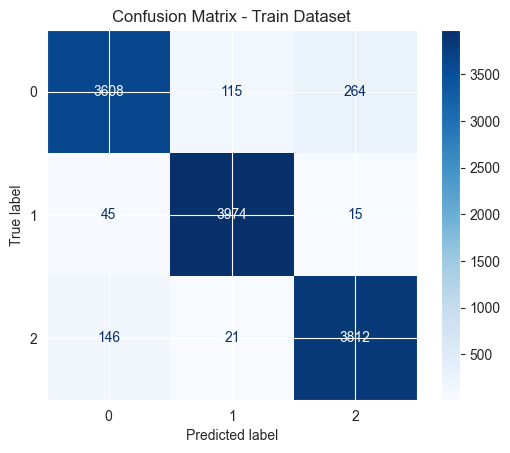

Validation Accuracy: 78.00%
Validation F1-Score: 0.7794


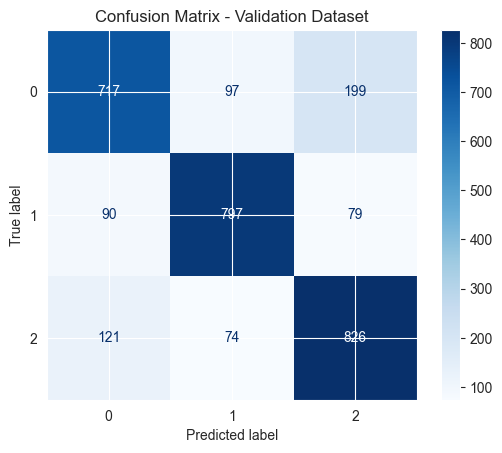

Test Accuracy: 81.17%
Test F1-Score: 0.8113


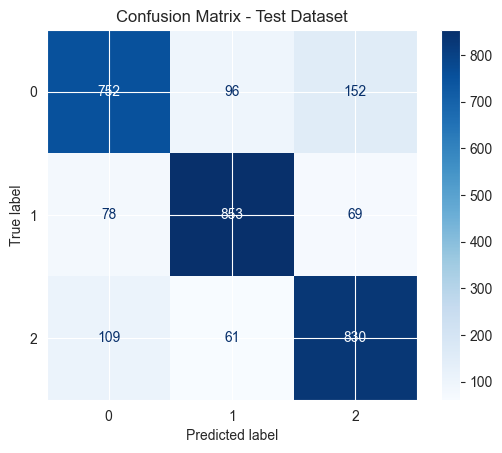

In [115]:
model = MLP(3*32*32 , 3)
model.load_state_dict(torch.load("mlp.pth"))
model.eval()

print(model)

evaluation(model, train_loader, "Train")
evaluation(model, val_loader, "Validation")
evaluation(model, test_loader, "Test")